### EDA
Frankly, there already are tools that can automate our EDA (eg Pandas Profiling, SweetViz etc). We neednt have llama code it out for us. However the point of this repo is to see what llama is capable of. In the "raw" series of notebooks I'll only make very slight edits so that the code works with our data. Otherwise what you see here is what i saw when entering my prompts

This is my first time using an LLM for code generation. I'm not too sure what to ask it first. How about:

**Prompt:** An exploratory data analysis using pandas. examine pairwise relationships

**Result:**

In [1]:
import pandas as pd

df = pd.read_csv('../Data/telco_data.csv')
print(df.head())
print(df.tail())
print(df.shape)
print(df.dtypes)
print(df.describe())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

Messy (it could print some strings between things), but standard stuff so far.

In [ ]:
df.fillna(df.mean(), inplace=True)

The above cell will not work. The LLM did not know the nature of my data. It has many categorical columns. It makes no sense to take a mean. Even for numerical columns, it may not be appropriate to get the mean to fill missing values. The LLM is presumptuous.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

We cannot get correlations unless all columns are numerical. The LLM ought to have specified numerical dtypes for this one. Lets quickly edit it and try below

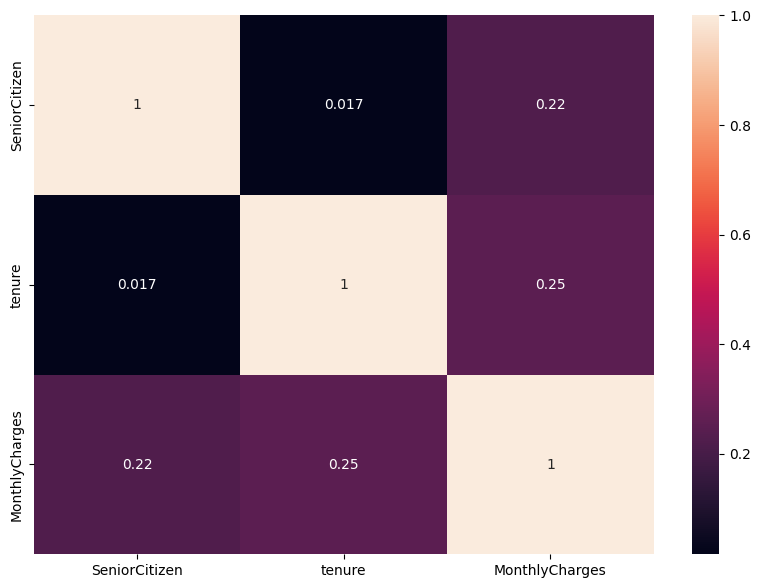

In [2]:
#Intervened
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

I suppose that fufils the "examine pairwise relationships" part of the prompt. At least for numeric columns (after i intervened).

In [4]:
#intervened (I had to input columns names)
tab = pd.crosstab(
   index=df['gender'],
   columns=df['Churn'],
)
print(tab)


Churn     No  Yes
gender           
Female  2549  939
Male    2625  930


Yup, Could do more with this. Something that compares all 2 way combos. Something that shows proportions rather than nominal figures.

We have a lot of categorical variables. Let's examine them

**Prompt:** I have a pandas dataframe. For each column print the column name and its unique values unless the number of unique values is more than 10. If a column does have more than 10 unique values then just print the column name and the number of unique values it has.

**Result:**

In [5]:
for col in df:
    unique_vals = df[col].unique()
    if len(unique_vals) > 10:
        print(col, len(unique_vals))
    else:
        print(col, unique_vals)

customerID 7043
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure 73
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges 1585
TotalCharges 6531
Churn ['No' 'Yes']


Nice, I'd format things a bit differently but since i didnt go into detail on that, I give the LLM full marks!

Lets see the proportions of each value for each variable in our dataset

**Prompt:** I have a pandas dataframe. For each column that is for a categorical variable, I want to see the proportion of each unique value has.

**Result:**

In [ ]:
proportions_dict = {}
for col in categorical_cols:
    counts = df[col].value_counts()
    proportions = counts / len(df)
    proportions_dict[col] = proportions

Ok. Its assumed a new variable called "categorical_cols". So this wont work. However the LLM's commentary did say "In this code, categorical_cols should be a list of the column names of the categorical variables in your dataframe."

Since it cant see my data and i didnt tell it to isolate my categorical columns, I think this is fair. So lets intervene and get those cat cols

In [6]:
#intervened to get categorical_cols and print the result
categorical_cols = list(df.select_dtypes(exclude=['number']).columns)

proportions_dict = {}
for col in categorical_cols:
    counts = df[col].value_counts()
    proportions = counts / len(df)
    proportions_dict[col] = proportions

print(proportions_dict)

{'customerID': customerID
7590-VHVEG    0.000142
3791-LGQCY    0.000142
6008-NAIXK    0.000142
5956-YHHRX    0.000142
5365-LLFYV    0.000142
                ...   
9796-MVYXX    0.000142
2637-FKFSY    0.000142
1552-AAGRX    0.000142
4304-TSPVK    0.000142
3186-AJIEK    0.000142
Name: count, Length: 7043, dtype: float64, 'gender': gender
Male      0.504756
Female    0.495244
Name: count, dtype: float64, 'Partner': Partner
No     0.516967
Yes    0.483033
Name: count, dtype: float64, 'Dependents': Dependents
No     0.700412
Yes    0.299588
Name: count, dtype: float64, 'PhoneService': PhoneService
Yes    0.903166
No     0.096834
Name: count, dtype: float64, 'MultipleLines': MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: count, dtype: float64, 'InternetService': InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: count, dtype: float64, 'OnlineSecurity': OnlineSecurity
No                    

Messy but it works. This exposes my own shortcomings actually. "TotalCharges" ought not to be there, I should more carefully examine the data and not just rely on dtypes. One must be thorough with these LLMs and never assume too much, especially when handling data that you know it cant see.

Follow up prompt

**Prompt:** Plot each of the proportions in a pie chart

**Result:**

In [ ]:
for col, proportions in proportions_dict.items():
    proportions.plot(kind='pie', autopct='%1.1f%%')
    plt.title(col)
    plt.ylabel('')
    plt.show()

I must intervene again because there are some columns with many unique values and so plotting a proportion chart of them would take too long. This is not the fault of the LLM

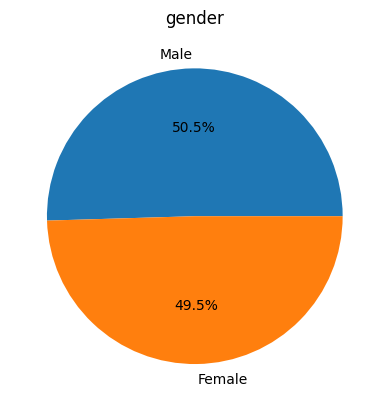

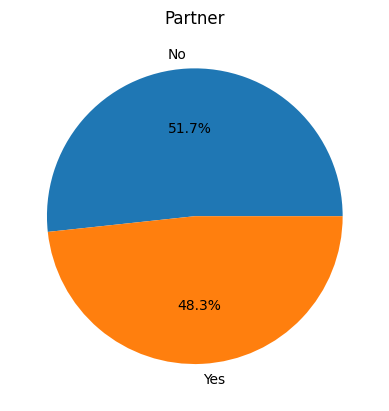

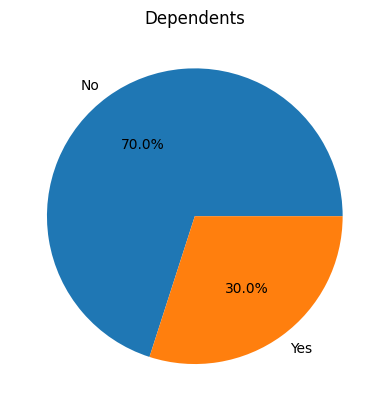

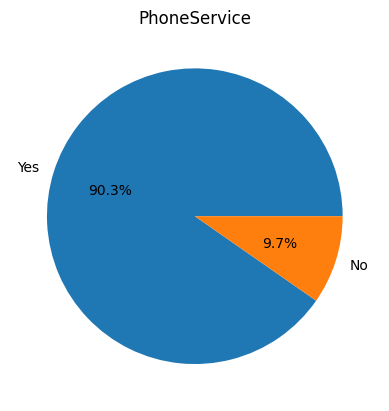

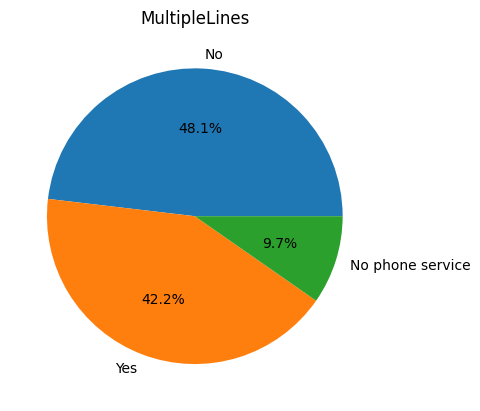

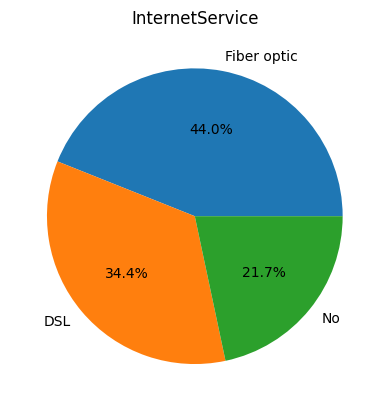

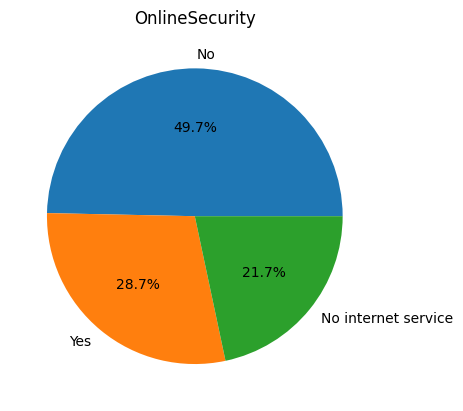

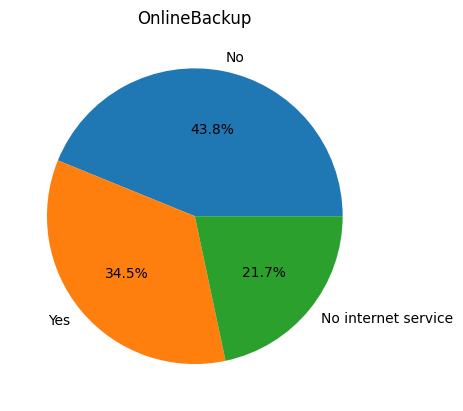

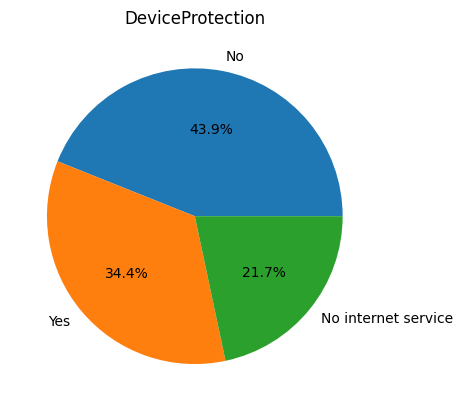

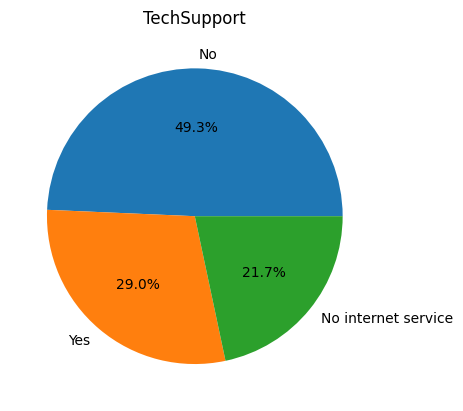

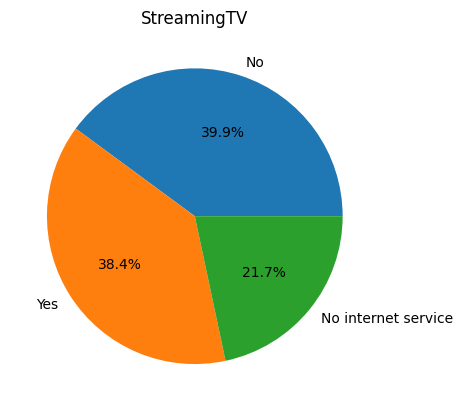

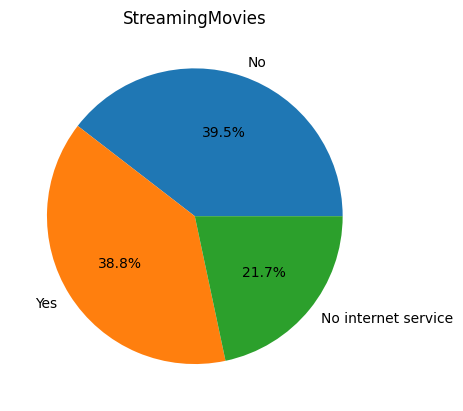

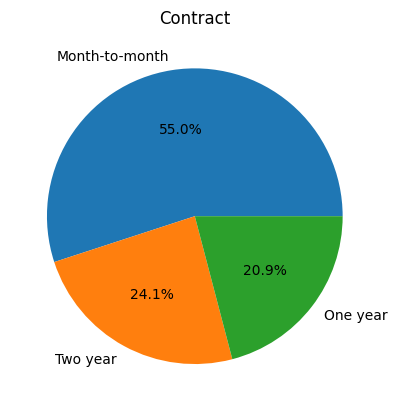

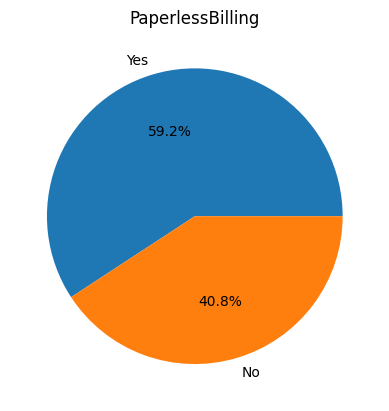

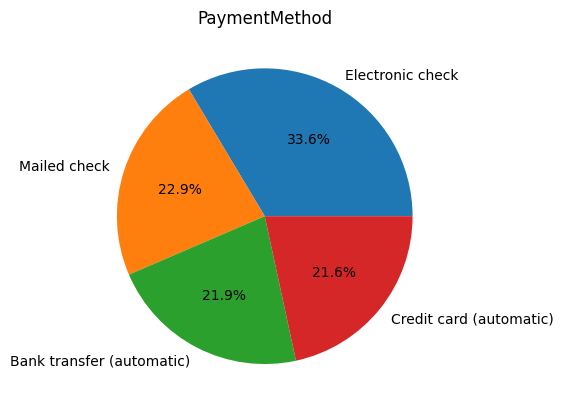

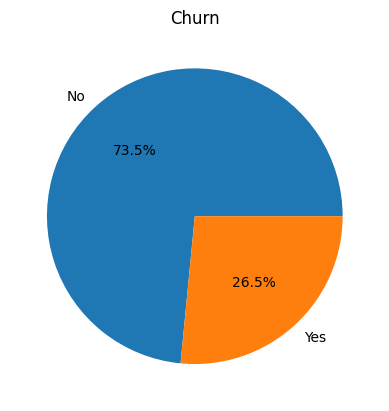

In [7]:
#Intervened - small number of unqiue vals only
for col, proportions in proportions_dict.items():
    if len(proportions) <= 8:
        proportions.plot(kind='pie', autopct='%1.1f%%')
        plt.title(col)
        plt.ylabel('')
        plt.show()

Lets take a look at the distributions of our numeric features

**Prompt:** I have a pandas dataframe. Plot histograms and box plots for the columns that have dtypes of float or integer.

**Result:** 

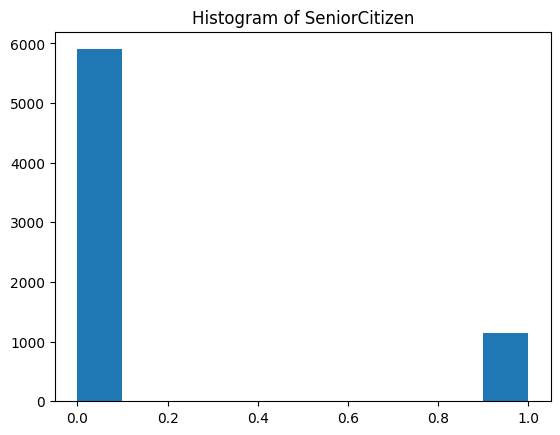

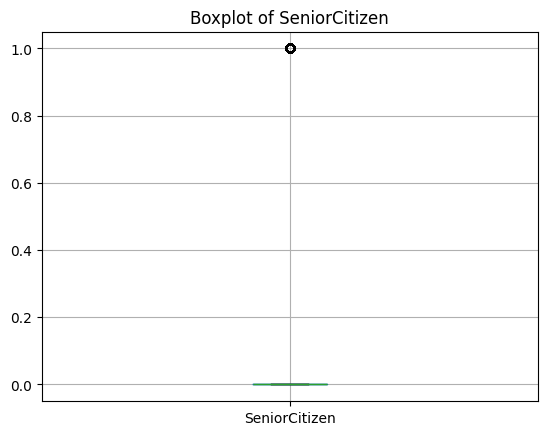

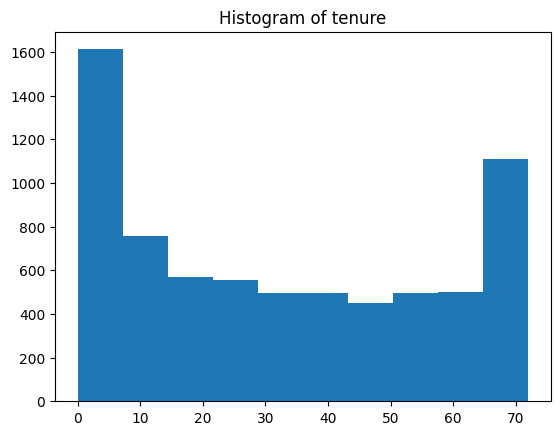

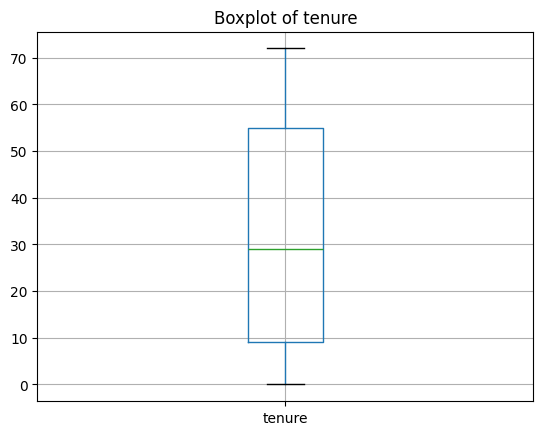

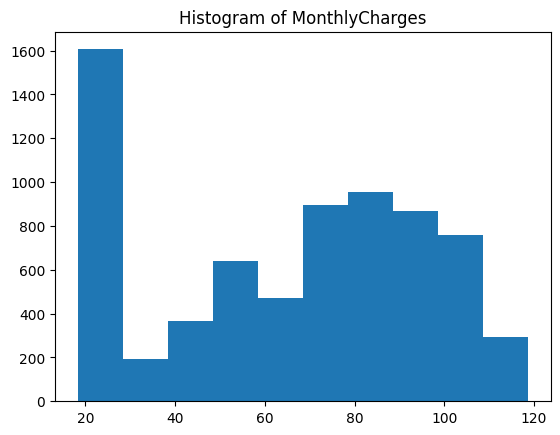

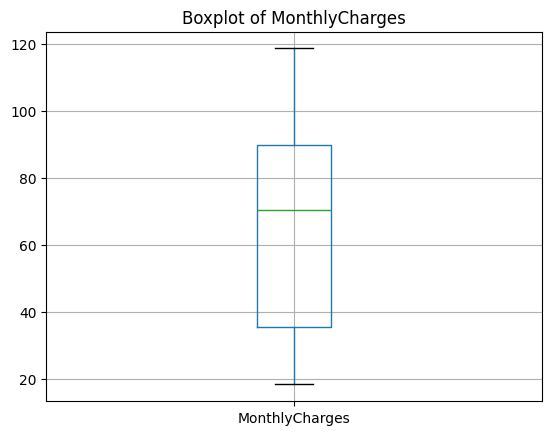

In [8]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
for column in df_numeric:
    plt.figure()
    plt.hist(df_numeric[column])
    plt.title(f'Histogram of {column}')
    plt.show()

    plt.figure()
    df_numeric.boxplot([column])
    plt.title(f'Boxplot of {column}')
    plt.show()

Nicely done. I know TotalCharges should be there but its data needs to be cleaned first so that it all conforms to being a float or integer.

Lets compare our categorical variables against the response variable Churn. This will be the most intricate prompt yet.

**Prompt:** I have a pandas dataframe. Create a list of column names where each column has less than 6 unique values. Create dummy variable columns from these in a separate dataframe. Attach a column called “Churn” from the old dataframe onto this new one. Get the mean value of each dummy variable column when “Churn” is equal to “Yes”. Plot these values in a vertical bar chart.

**Result:** 

In [ ]:
columns_to_dummify = [col for col in df.columns if df[col].nunique() < 6]
df_dummies = pd.get_dummies(df[columns_to_dummify])
df_dummies['Churn'] = df['Churn']
mean_values = df_dummies[df_dummies['Churn'] == 'Yes'].mean()

plt.barh(mean_values.index, mean_values.values)
plt.ylabel('Dummy Variables')
plt.xlabel('Mean Value')
plt.title('Mean Value of Dummy Variables when Churn is Yes')
plt.show()

This will not work. When it calculates the mean, it forgot to exclude the Churn column itself which still has string values. Simple to fix though!

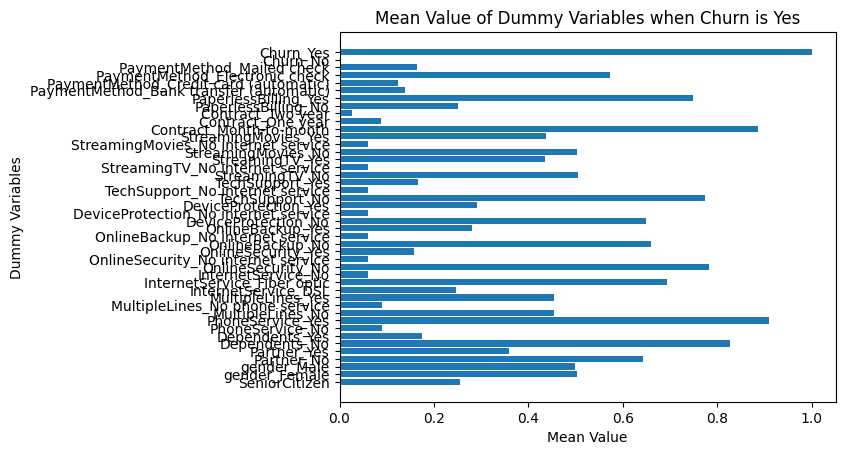

In [8]:
#Intervened - mean calc
columns_to_dummify = [col for col in df.columns if df[col].nunique() < 6]
df_dummies = pd.get_dummies(df[columns_to_dummify])
df_dummies['Churn'] = df['Churn']
mean_values = df_dummies[df_dummies['Churn'] == 'Yes'].drop('Churn', axis=1).mean()

plt.barh(mean_values.index, mean_values.values)
plt.ylabel('Dummy Variables')
plt.xlabel('Mean Value')
plt.title('Mean Value of Dummy Variables when Churn is Yes')
plt.show()

Lets clean that up a bit

**Prompt:** can you order it from highest to lowest?

**Result:** 

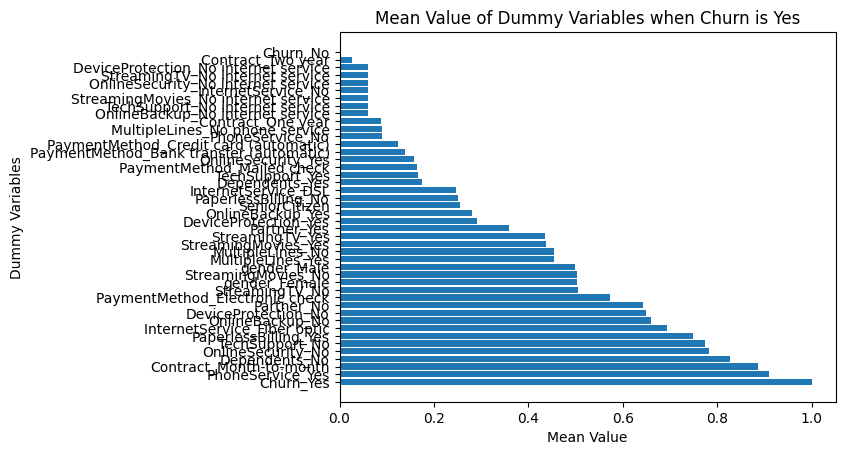

In [10]:
# Sort the mean values from highest to lowest
mean_values = mean_values.sort_values(ascending=False)
plt.barh(mean_values.index, mean_values.values)
plt.ylabel('Dummy Variables')
plt.xlabel('Mean Value')
plt.title('Mean Value of Dummy Variables when Churn is Yes')
plt.show()

Yeah, not bad! Now we can see how each categorical feature impacts the Churn variable. I'll just change the figsize so it is more readable

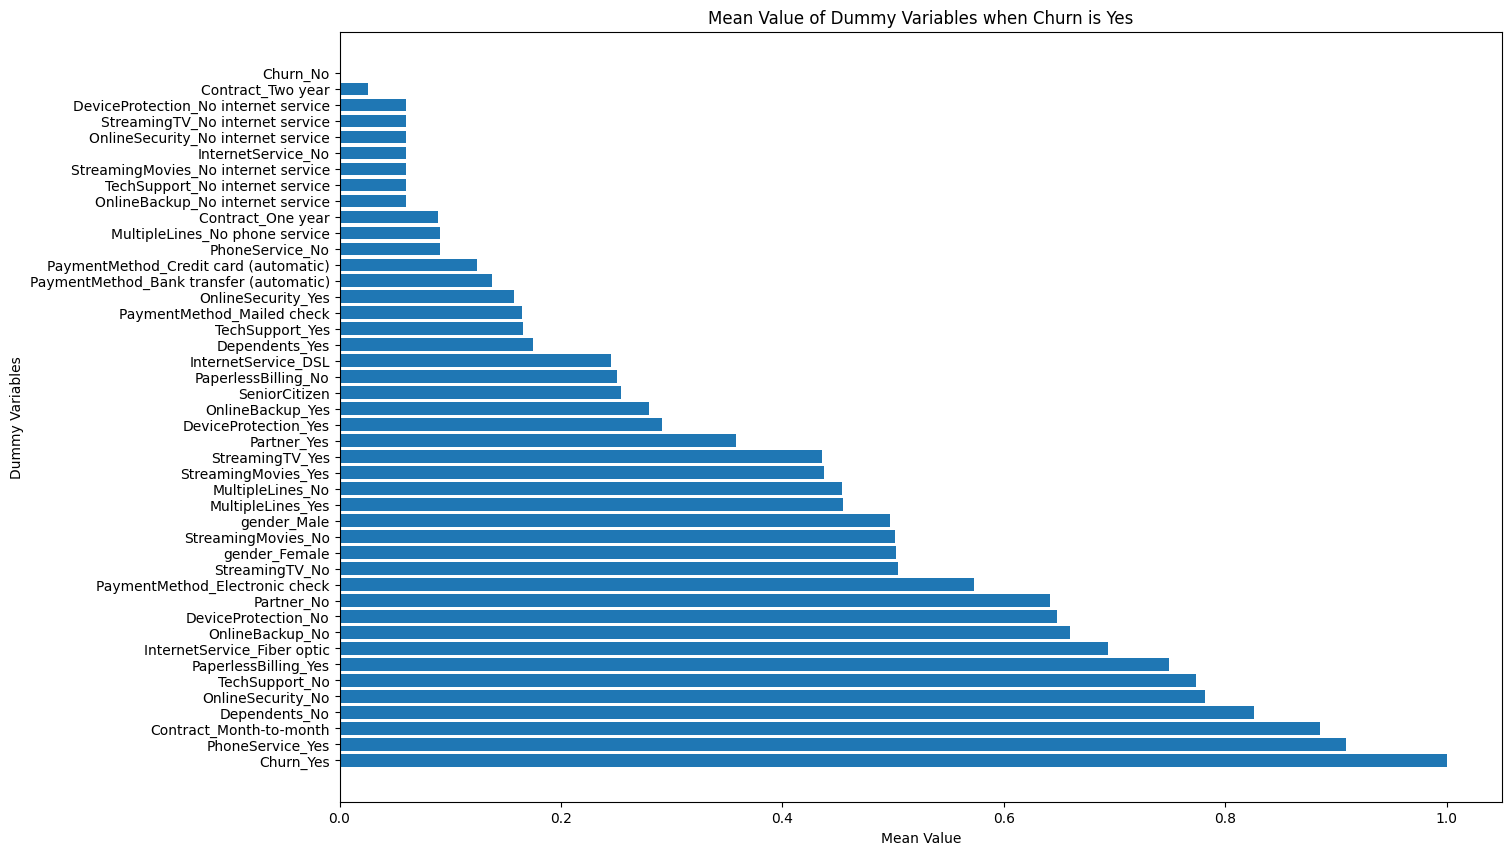

In [24]:
#Intervened - figsize increase for readability
plt.figure(figsize = (15,10))
plt.barh(mean_values.index, mean_values.values)
plt.ylabel('Dummy Variables')
plt.xlabel('Mean Value')
plt.title('Mean Value of Dummy Variables when Churn is Yes')
plt.show()

Let's leave the EDA there. This is a good companion. Clearly its been trained on stackoverflow (it keeps giving it as a source) and its suggestions do seem to align with the things I was seeing on that site many years ago when i was learning these libraries.
Its not perfect but part of the problem is me, I took a few things for granted and did not make my prompts specific enough.
What would be great is if the LLM could see your data as well - if it could go beyond just the coding side of things. I'm sure we'll see such a thing soon enough!